As with some previous figures, the infectious seed isn't specified
which is presumably the reason why the curves aren't absolutely identical.
Here, Vynnycky and White may not be using a numeric simulation,
but rather calculating the epidemic final size from an analytic expression,
but has been reproduced with `summer` anyway.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from summer2 import CompartmentalModel
from summer2.parameters import Parameter

In [2]:
def build_sir_model(
    config: dict,
) -> CompartmentalModel:
    
    # Model characteristics
    compartments = (
        "susceptible",
        "infectious",
        "recovered",
    )
    analysis_times = (0., config["end_time"])
    model = CompartmentalModel(
        times=analysis_times,
        compartments=compartments,
        infectious_compartments=["infectious"],
        timestep=0.01,
    )
    model.set_initial_population(
        distribution=
        {
            "susceptible": config["total_population"] - config["infectious_seed"], 
            "infectious": config["infectious_seed"],
        }
    )
    
    # Transitions
    infectious_period = Parameter("infectious_period")
    model.add_infection_frequency_flow(
        name="infection", 
        contact_rate=Parameter("r0") / infectious_period,
        source="susceptible", 
        dest="infectious",
    )
    model.add_transition_flow(
        name="recovery", 
        fractional_rate=1. / infectious_period,
        source="infectious", 
        dest="recovered",
    )
    
    return model

In [3]:
model_config = {
    "end_time": 20.,
    "total_population": 1.,
    "infectious_seed": 0.001,
}

parameters = {
    "infectious_period": 1.,
}

In [4]:
r0s = np.linspace(0.99, 15., 100)
outputs = []
sir_model = build_sir_model(model_config)
for r0 in r0s:
    parameters.update({"r0": r0})
    sir_model.run(parameters=parameters, solver="euler")
    outputs.append(1. - sir_model.get_outputs_df()["susceptible"].iloc[-1])

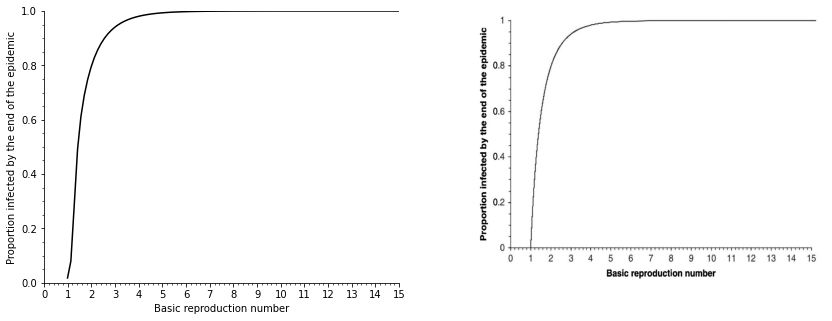

In [5]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))

left_ax.plot(
    r0s,
    outputs,
    color="k",
)
left_ax.set_xlim(0., 15.)
left_ax.set_xticks(range(0, 16))
left_ax.xaxis.set_minor_locator(AutoMinorLocator(5))
left_ax.set_xlabel("Basic reproduction number")
left_ax.set_ylim(0., 1.)
left_ax.yaxis.set_minor_locator(AutoMinorLocator(4))
left_ax.set_ylabel("Proportion infected by the end of the epidemic")
left_ax.spines.top.set_visible(False)
left_ax.spines.right.set_visible(False)

image = plt.imread("./figures/fig_4_12.jpg")
right_ax.axis("off")
right_ax.imshow(image, aspect="auto");